Import all necessary modules

In [1]:
# imports: this cell will have all the imports used in this notebook
import random
import time
import seaborn as sn
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats

from scipy import stats
from scipy.stats import bernoulli
from bitstring import BitArray

# sklearn imports
from sklearn.metrics import mean_squared_error, accuracy_score
from sklearn.model_selection import train_test_split as split
from sklearn.linear_model import LinearRegression
from sklearn.datasets import make_regression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score

# sklearn
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold

# sklearn genetics
from sklearn_genetic import GASearchCV
from sklearn_genetic.space import Integer, Categorical, Continuous
from sklearn_genetic.plots import plot_fitness_evolution, plot_search_space
from sklearn_genetic.callbacks import LogbookSaver, ProgressBar

c:\Users\ekbotchway.IMPACTLIFE\Desktop\CODE WORKS\QBE\thesis_work\venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Sklearn
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.ensemble import RandomForestRegressor

# importing the minmaxscaler to normalize data between 0 and 1
from sklearn.preprocessing import MinMaxScaler

# keres imports
from keras.layers import LSTM, Input, Dense, Dropout, Activation
from keras.models import Model
from keras.models import Sequential

# Deap for genetic algorithm imports
from deap import base, creator, tools, algorithms

# seeding to get reproducible results with Keras and numpy
from numpy.random import seed
import tensorflow

# used for displaying missing data
import missingno as msno

%matplotlib inline
from subprocess import check_output
%config Completer.use_jedi = False

In [3]:

# preprocessing 
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import minmax_scale
from sklearn.preprocessing import MaxAbsScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler
from sklearn.preprocessing import Normalizer
from sklearn.preprocessing import QuantileTransformer
from sklearn.preprocessing import PowerTransformer
from sklearn.gaussian_process.kernels import DotProduct, WhiteKernel
from sklearn.gaussian_process.kernels import RBF,  DotProduct, ConstantKernel as C
from sklearn.linear_model import BayesianRidge
from sklearn.neural_network import MLPRegressor
from scipy.stats import loguniform

from sklearn.model_selection import train_test_split
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import  mean_squared_error, r2_score, make_scorer

seed(1)
tensorflow.random.set_seed(2)

%matplotlib inline

Set image printing features

In [4]:
# Use TeX fonts
plt.rc("text", usetex=False)
plt.rc('font', **{'family': 'serif', 'serif': ['cmr10']})
plt.rc('font',**{'family':'sans-serif','sans-serif':['Helvetica']})
plt.rc('font', size=7.0)
plt.rc('font', weight='normal')
plt.rc('legend', fontsize=5)
plt.rc('axes', grid=False)
plt.rcParams['axes.labelsize'] = 7
plt.rcParams['xtick.labelsize'] = 5
plt.rcParams['ytick.labelsize'] = 5
plt.rcParams['figure.figsize'] = [11, 6.5]

Define input and output dataframes and view them

In [5]:
# read and convert csv data into a dataframe and print it out
df_inp = pd.read_csv("inputs_sample_m.csv")
df_inp = df_inp.dropna()
df_inp.head(n=10)

,COR_SC 1131,COR_SC 1132,COR_CMT,COR_EDR,COR_EDR (LP),COR_ZP,DC Power Limit,COR_CHT,COR_LP,COR_SC 1141,SRV LAMDA
0,2293.356662,2789.402256,0.230395,0.005509,0.024595,0.139081,3.918165,16911.306560,1906.512535,0.224355,0.100424
1,2327.973792,2654.097438,0.463208,0.017686,0.001503,0.331455,7.090109,11464.346490,2583.577445,0.770091,0.100134
2,2229.495518,2728.877450,0.119571,0.030271,0.001139,0.219394,3.956615,16847.739940,2036.271861,0.437037,0.100794
3,2169.838177,2711.497422,0.325962,0.017823,0.005905,0.466482,6.396841,8032.071485,2540.804117,0.265412,0.107670
4,2454.066629,2416.023124,0.150077,0.004228,0.009376,0.343951,3.413674,18880.585550,2298.552144,0.233114,0.104237
5,2157.928603,2423.728807,0.158060,0.002022,0.016421,0.171284,5.237637,11540.942380,2780.718438,0.305795,0.103095
6,2175.022605,2556.160791,0.114612,0.025801,0.010504,0.245718,3.532934,5684.961075,1623.582479,0.574269,0.103027
7,2329.388487,2640.571851,0.228932,0.026381,0.022747,0.423525,5.335959,10794.111880,3243.410569,0.347614,0.104575
8,2335.912325,2560.934896,0.239971,0.033231,0.001561,0.244234,3.939197,8500.876974,2761.312180,0.792433,0.104122
9,2456.125236,2543.395349,0.117940,0.008857,0.001054,0.382875,3.188109,13004.319390,2439.381116,0.350448,0.100373


In [6]:
df_out = pd.read_csv("output_sample_m.csv")
df_out = df_out.dropna()
df_out.head(n=10)

,H2,Temp,Press
0,32.265517,633.0,7360000.0
1,33.942989,671.0,7380000.0
2,37.661494,648.0,7400000.0
3,34.766782,649.0,7380000.0
4,28.771954,652.0,7380000.0
5,31.561494,638.0,7380000.0
6,34.642414,678.0,7380000.0
7,35.559195,672.0,7380000.0
8,40.568621,634.0,7380000.0
9,31.568046,641.0,7370000.0


array([[<Axes: title={'center': 'COR_SC 1131'}>,
        <Axes: title={'center': 'COR_SC 1132'}>,
        <Axes: title={'center': 'COR_CMT'}>],
       [<Axes: title={'center': 'COR_EDR'}>,
        <Axes: title={'center': 'COR_EDR (LP)'}>,
        <Axes: title={'center': 'COR_ZP'}>],
       [<Axes: title={'center': 'DC Power Limit'}>,
        <Axes: title={'center': 'COR_CHT'}>,
        <Axes: title={'center': 'COR_LP'}>],
       [<Axes: title={'center': 'COR_SC 1141'}>,
        <Axes: title={'center': 'SRV LAMDA'}>, <Axes: >]], dtype=object)

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

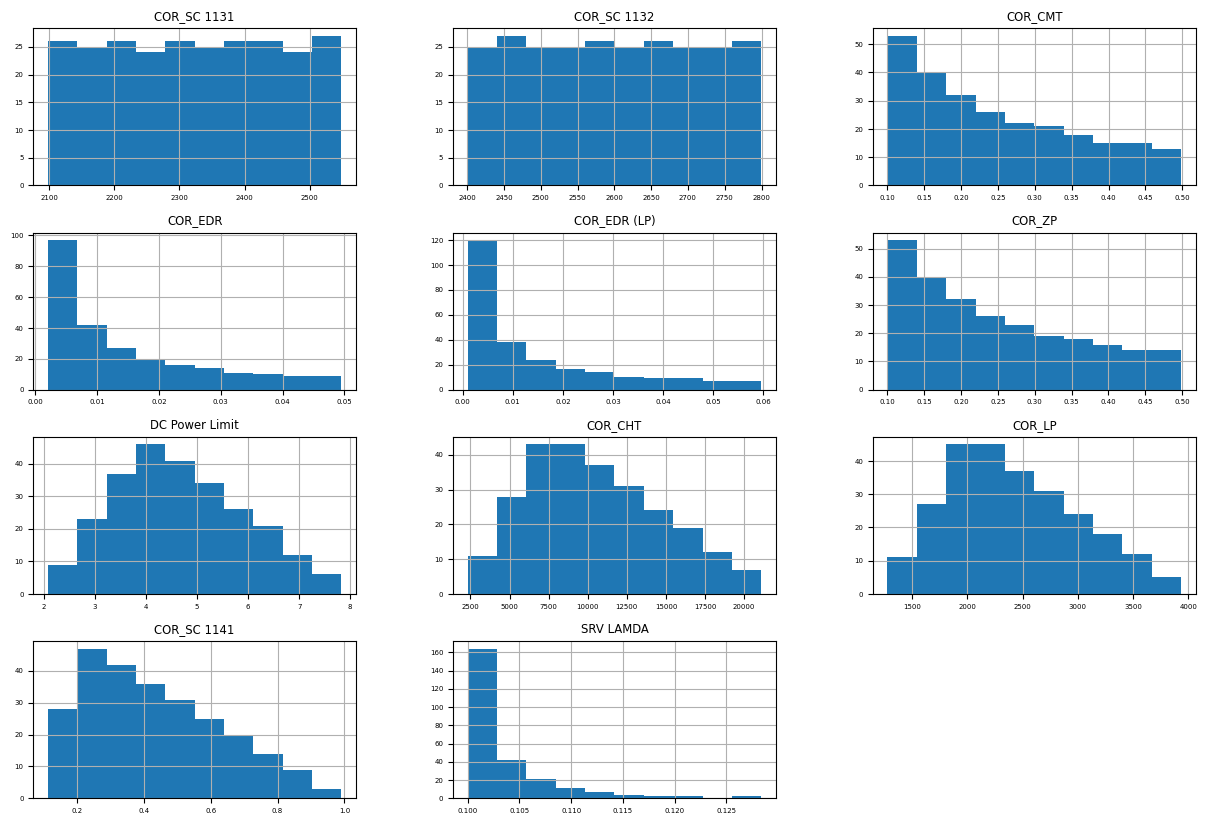

In [7]:
lst = list(df_inp.columns)
df_inp[lst].hist(figsize=(15,10))

Correlation 

In [8]:
corrMatrix = df_inp.corr()
print(corrMatrix)

                COR_SC 1131  COR_SC 1132   COR_CMT   COR_EDR  COR_EDR (LP)  \
COR_SC 1131        1.000000    -0.021871 -0.021348 -0.051601      0.001906   
COR_SC 1132       -0.021871     1.000000  0.012306 -0.017805      0.000490   
COR_CMT           -0.021348     0.012306  1.000000 -0.043834      0.012183   
COR_EDR           -0.051601    -0.017805 -0.043834  1.000000     -0.000222   
COR_EDR (LP)       0.001906     0.000490  0.012183 -0.000222      1.000000   
COR_ZP            -0.033348     0.002640  0.004389  0.020851      0.063374   
DC Power Limit    -0.003258    -0.004286  0.019668 -0.002754     -0.000468   
COR_CHT            0.015952     0.005398  0.004114 -0.012110      0.007393   
COR_LP            -0.013695    -0.016836 -0.005105  0.003332     -0.004690   
COR_SC 1141       -0.008387     0.031586  0.029679 -0.012488      0.031279   
SRV LAMDA         -0.022340     0.042773 -0.048710 -0.021678      0.011199   

                  COR_ZP  DC Power Limit   COR_CHT    COR_LP  C

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

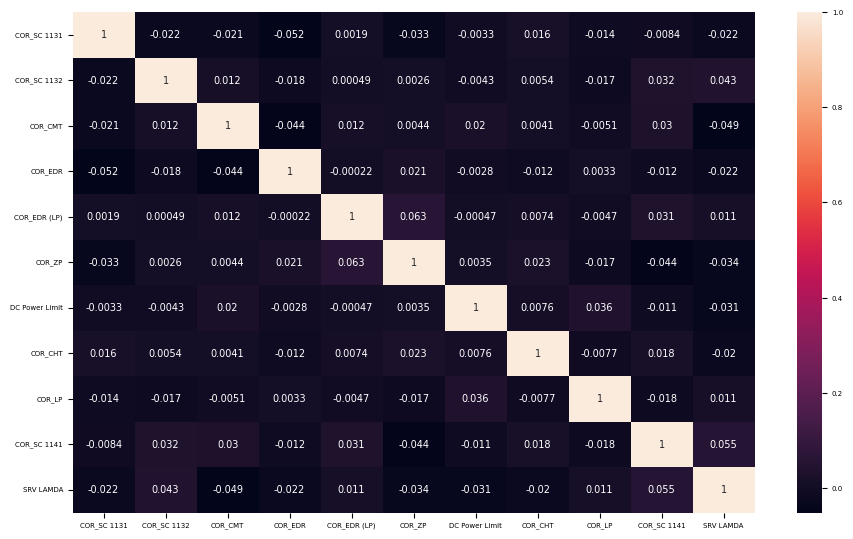

In [9]:
sn.heatmap(corrMatrix, annot=True)
plt.show()

In [10]:
# finding correlation between the inputs and outputs
corrl = df_inp.corrwith(df_out["H2"])   # we first find for Hydrogen production
corr2 = df_inp.corrwith(df_out["Temp"])  # we then find for Temprature
corr3 = df_inp.corrwith(df_out["Press"])   # we then find for Pressure
print("Correlation of the input data with Hydrogen production")
print(corrl)
print("\n")
print("Correlation of the input data with Temprature")
print(corr2)
print("\n")
print("Correlation of the input data with Pressure")
print(corr3)

Correlation of the input data with Hydrogen production
COR_SC 1131      -0.008814
COR_SC 1132      -0.016751
COR_CMT          -0.019871
COR_EDR           0.308190
COR_EDR (LP)      0.113913
COR_ZP           -0.028185
DC Power Limit   -0.072358
COR_CHT           0.044350
COR_LP            0.059786
COR_SC 1141       0.010941
SRV LAMDA         0.008188
dtype: float64


Correlation of the input data with Temprature
COR_SC 1131      -0.049478
COR_SC 1132      -0.098673
COR_CMT           0.009378
COR_EDR           0.290936
COR_EDR (LP)      0.070269
COR_ZP           -0.080209
DC Power Limit   -0.120217
COR_CHT          -0.037013
COR_LP            0.083050
COR_SC 1141      -0.040943
SRV LAMDA        -0.019102
dtype: float64


Correlation of the input data with Pressure
COR_SC 1131      -0.101491
COR_SC 1132       0.068950
COR_CMT          -0.009571
COR_EDR           0.188102
COR_EDR (LP)      0.041235
COR_ZP            0.096912
DC Power Limit   -0.036515
COR_CHT          -0.002369
COR_LP     

Ploting the pearson's correlation in a horizontal bar graph between the inputs and each output

<BarContainer object of 11 artists>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

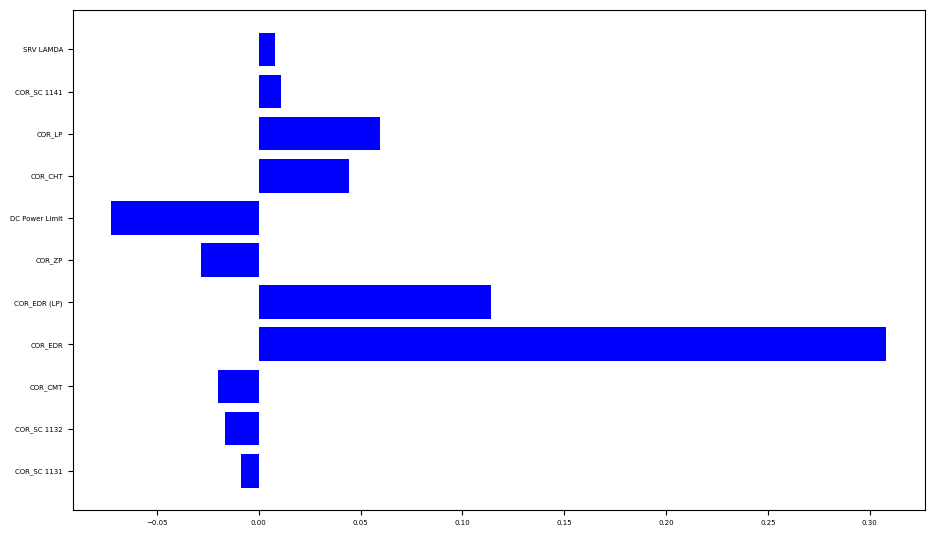

In [11]:
# Now plotting Pearson's r between inputs and outputs
inputs_or = df_inp.columns.to_list()

plt.barh(inputs_or,corrl,color='blue') # blue for plot for hydrogen production

<BarContainer object of 11 artists>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

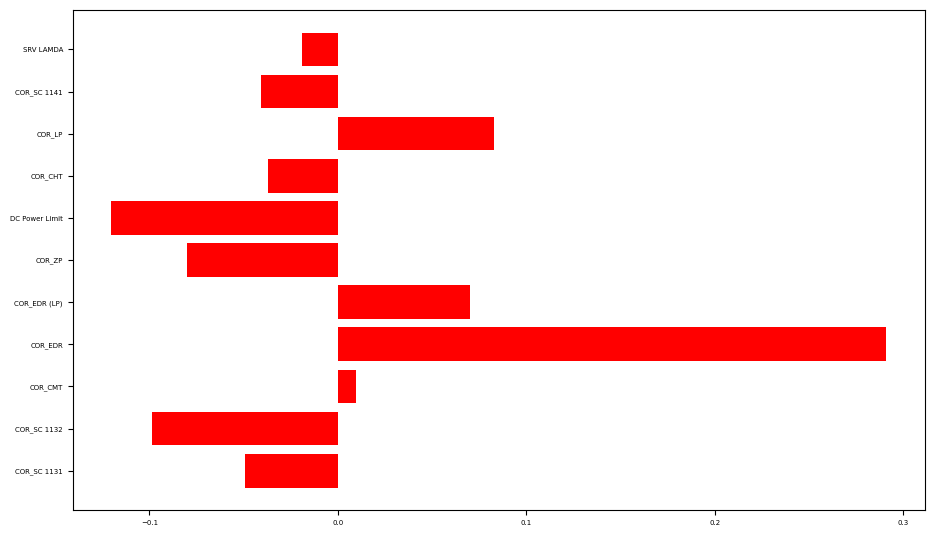

In [12]:
plt.barh(inputs_or,corr2,color='red') # red for plot for Tempreature

<BarContainer object of 11 artists>

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

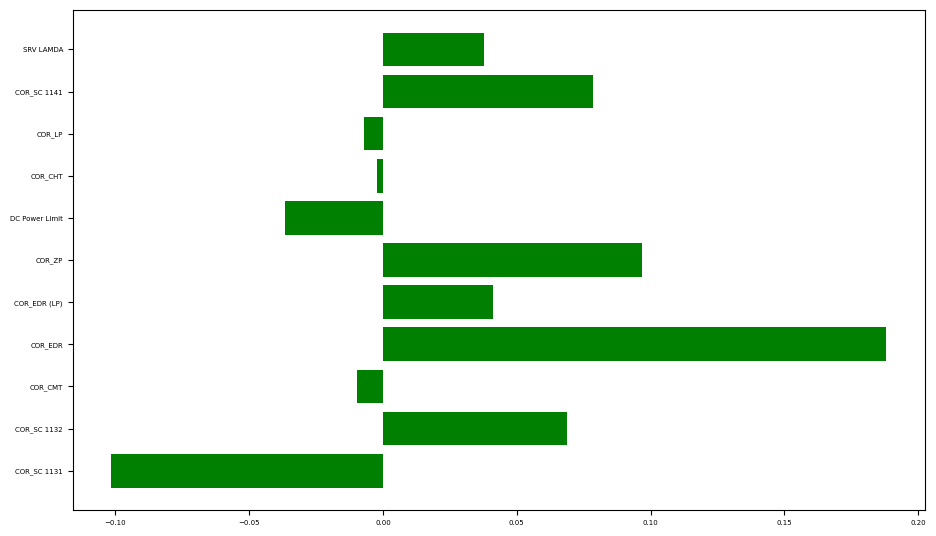

In [13]:
plt.barh(inputs_or,corr3,color='green') # green for plot for pressure

Calculating the Spearman's P Values between the inputs and each output

In [14]:
# find the p-value of the data and print it out
pph_val = []
for i in inputs_or:
    pcor, pval = stats.spearmanr(df_inp[i],df_out["H2"])   # we first find for Hydrogen production
    pph_val.append(pval)
print(pph_val)

[0.33221969220889447, 0.8882161553122979, 0.5979050724931116, 4.123575379780675e-19, 0.03529208258638605, 0.446594118308131, 0.6733913260985449, 0.7748076748524522, 0.2016029127590702, 0.20876122109467704, 0.27406686712233963]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

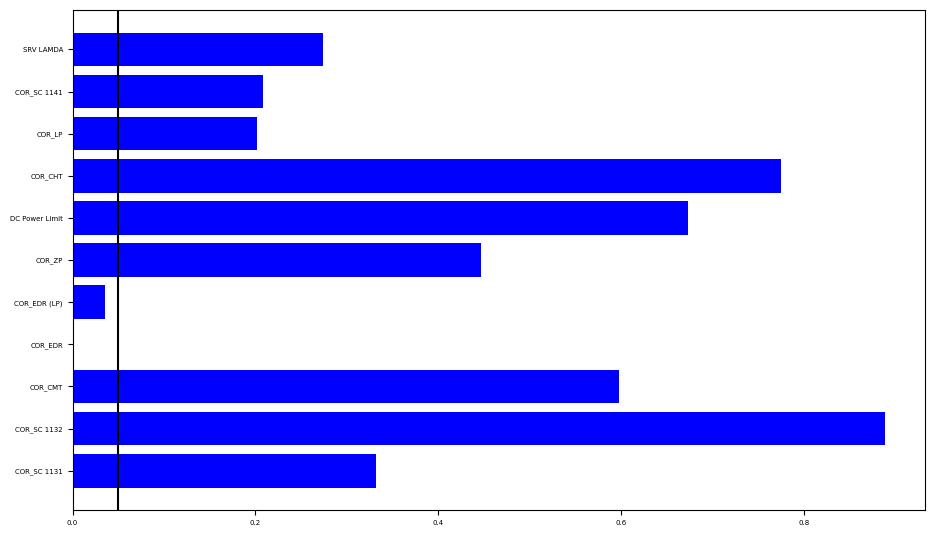

In [15]:
plt.barh(inputs_or,pph_val,color='blue') # blue for p-values of input with hydrogen production
plt.axvline(x=0.05,color='black')

In [16]:
# find the p-value of the data and print it out
ppt_val = []
for i in inputs_or:
    pcor, pval = stats.spearmanr(df_inp[i],df_out["Temp"])   # then find for temperature
    ppt_val.append(pval)
print(ppt_val)

[0.3327334491101537, 0.09223956743358802, 0.8136161014833851, 8.595845292650391e-08, 0.07421357995285299, 0.39665871123179, 0.07150322563328065, 0.2902446654073348, 0.2265093620422859, 0.4248475980961357, 0.8864160878720241]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

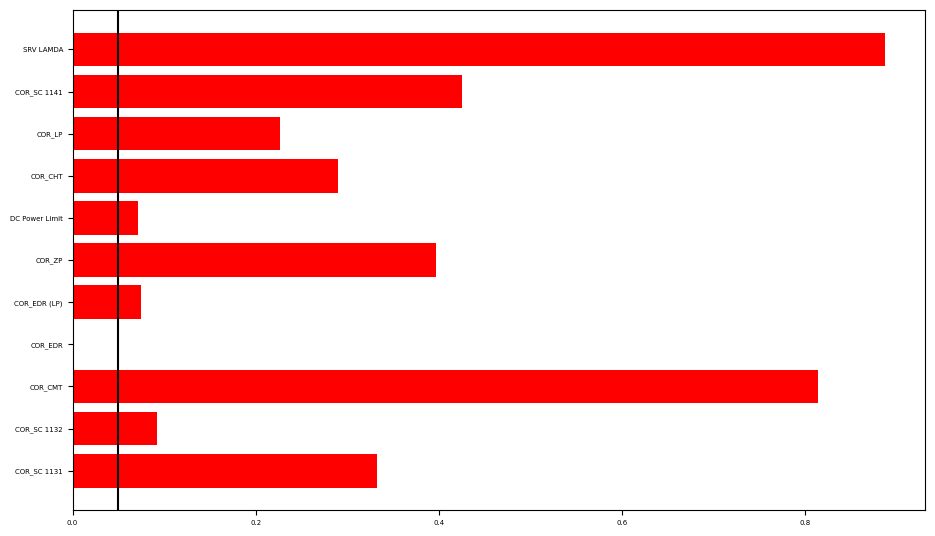

In [17]:
plt.barh(inputs_or,ppt_val,color='red') # red for p-values of input with Tempreature
plt.axvline(x=0.05,color='black')

In [18]:
# find the p-value of the data and print it out
ppp_val = []
for i in inputs_or:
    pcor, pval = stats.spearmanr(df_inp[i],df_out["Press"])   # then find for pressure
    ppp_val.append(pval)
print(ppp_val)

[0.07460250436594809, 0.2908713223571171, 0.93769598437798, 0.0013505405882310079, 0.5065233266936672, 0.11118526427577376, 0.579365779347415, 0.7691728803046135, 0.9617051785536103, 0.13885205696679223, 0.11763534489211717]


findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

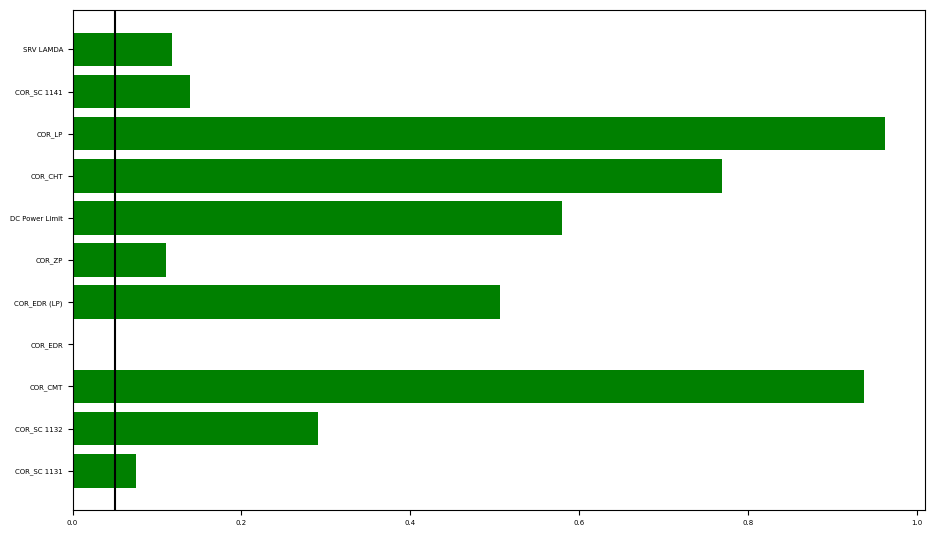

In [19]:
plt.barh(inputs_or,ppp_val,color='green') # green for p-values of input with pressure
plt.axvline(x=0.05,color='black')

Base Graphs

In [20]:
dfb = pd.read_csv("base_sample.csv")
dfb

,Time,H2,Press,Temp
0,0.000000,0.00,6330000.0,552.0
1,0.033531,0.00,7300000.0,562.0
2,0.066797,0.00,7120000.0,560.0
3,0.100022,0.00,7300000.0,562.0
4,0.133469,0.00,7430000.0,563.0
...,...,...,...,...
82,2.734022,269.43,7610000.0,2050.0
83,2.767092,278.48,7500000.0,2080.0
84,2.778203,279.92,7510000.0,2140.0
85,4.167061,442.55,7530000.0,1680.0


Text(0, 0.5, 'Hydrogen/ quantity generated')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

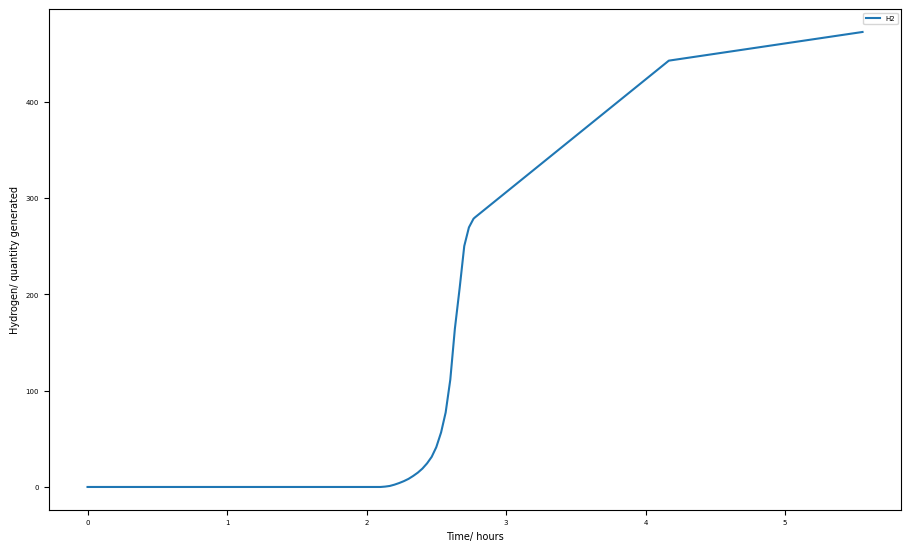

In [21]:
dfb.plot(x='Time', y='H2')
plt.xlabel("Time/ hours")
plt.ylabel("Hydrogen/ quantity generated")

Text(0, 0.5, 'Pressure/ Pa')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

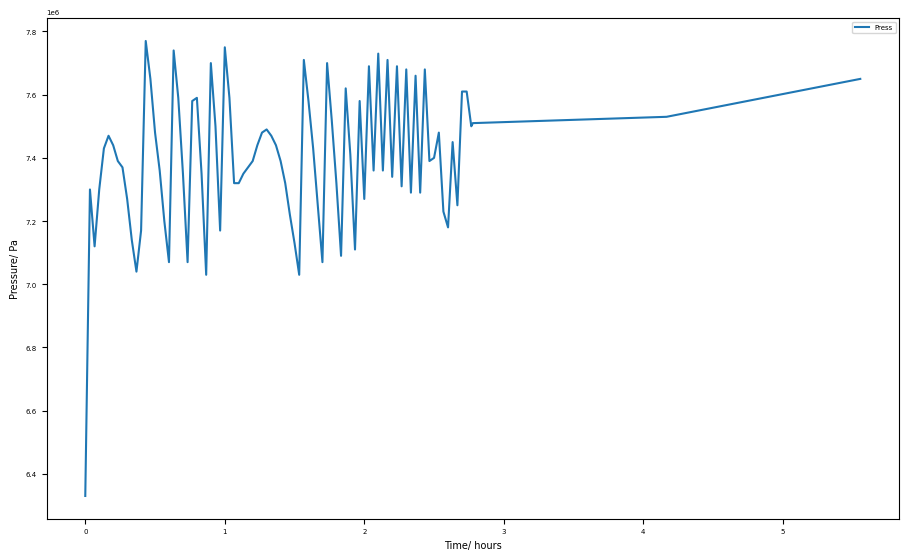

In [22]:
dfb.plot(x='Time', y='Press')
plt.xlabel("Time/ hours")
plt.ylabel("Pressure/ Pa")

Text(0, 0.5, 'Tempreature/ K')

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

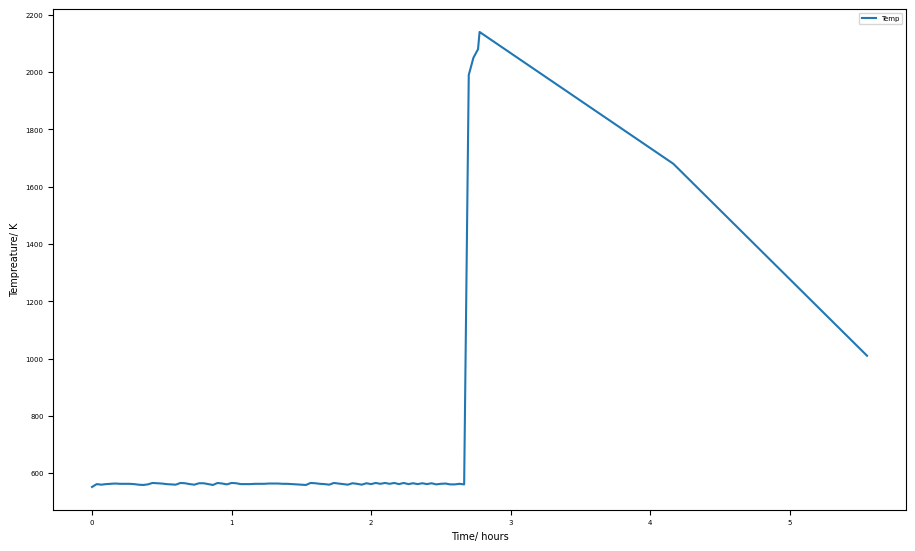

In [23]:
dfb.plot(x='Time', y='Temp')
plt.xlabel("Time/ hours")
plt.ylabel("Tempreature/ K")

Data cleaning process

In [24]:
# we will use the combined data now.
df = pd.read_csv("data.csv")
df.head(n=10)

,COR_SC 1131,COR_SC 1132,COR_CMT,COR_EDR,COR_EDR (LP),COR_ZP,DC Power Limit,COR_CHT,COR_LP,COR_SC 1141,SRV LAMDA,H2,Temp,Press
0,2293.356662,2789.402256,0.230395,0.005509,0.024595,0.139081,3.918165,16911.306560,1906.512535,0.224355,0.100424,32.265517,633,7360000
1,2327.973792,2654.097438,0.463208,0.017686,0.001503,0.331455,7.090109,11464.346490,2583.577445,0.770091,0.100134,33.942989,671,7380000
2,2229.495518,2728.877450,0.119571,0.030271,0.001139,0.219394,3.956615,16847.739940,2036.271861,0.437037,0.100794,37.661494,648,7400000
3,2169.838177,2711.497422,0.325962,0.017823,0.005905,0.466482,6.396841,8032.071485,2540.804117,0.265412,0.107670,34.766782,649,7380000
4,2454.066629,2416.023124,0.150077,0.004228,0.009376,0.343951,3.413674,18880.585550,2298.552144,0.233114,0.104237,28.771954,652,7380000
5,2157.928603,2423.728807,0.158060,0.002022,0.016421,0.171284,5.237637,11540.942380,2780.718438,0.305795,0.103095,31.561494,638,7380000
6,2175.022605,2556.160791,0.114612,0.025801,0.010504,0.245718,3.532934,5684.961075,1623.582479,0.574269,0.103027,34.642414,678,7380000
7,2329.388487,2640.571851,0.228932,0.026381,0.022747,0.423525,5.335959,10794.111880,3243.410569,0.347614,0.104575,35.559195,672,7380000
8,2335.912325,2560.934896,0.239971,0.033231,0.001561,0.244234,3.939197,8500.876974,2761.312180,0.792433,0.104122,40.568621,634,7380000
9,2456.125236,2543.395349,0.117940,0.008857,0.001054,0.382875,3.188109,13004.319390,2439.381116,0.350448,0.100373,31.568046,641,7370000


In [25]:
# we check for n/a values
df.isna().any()

COR_SC 1131       False
COR_SC 1132       False
COR_CMT           False
COR_EDR           False
COR_EDR (LP)      False
COR_ZP            False
DC Power Limit    False
COR_CHT           False
COR_LP            False
COR_SC 1141       False
SRV LAMDA         False
H2                False
Temp              False
Press             False
dtype: bool

In [26]:
# we check for duplicate values
df.duplicated().sum()

0

In [27]:
# scale all the data 
scaler = MinMaxScaler()

# scale all data
df_scaled = scaler.fit_transform(df.values)
df_scaled

# turn array scaled to dataframe
df_sc = pd.DataFrame(df_scaled, columns = [df.columns])
df_sc

,COR_SC 1131,COR_SC 1132,COR_CMT,COR_EDR,COR_EDR (LP),COR_ZP,DC Power Limit,COR_CHT,COR_LP,COR_SC 1141,SRV LAMDA,H2,Temp,Press
0,0.433196,0.974327,0.326729,0.073381,0.402796,0.097497,0.320306,0.777087,0.237187,0.127303,0.014931,0.704269,0.529851,0.00
1,0.510020,0.635153,0.912067,0.329615,0.008461,0.580681,0.871720,0.486867,0.491747,0.748363,0.004736,0.743555,0.813433,0.50
2,0.291472,0.822607,0.048097,0.594436,0.002245,0.299218,0.326990,0.773700,0.285973,0.369341,0.027976,0.830642,0.641791,1.00
3,0.159077,0.779040,0.567005,0.332502,0.083635,0.919829,0.751202,0.303992,0.475665,0.174028,0.270308,0.762848,0.649254,0.50
4,0.789852,0.038363,0.124796,0.046430,0.142897,0.612067,0.232605,0.882012,0.384584,0.137272,0.149319,0.622450,0.671642,0.50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
250,0.768304,0.543422,0.698539,0.036094,0.001026,0.677452,0.197645,0.118760,0.141515,0.669435,0.045011,0.699682,0.552239,0.50
251,0.887487,0.579299,0.225274,0.103593,0.031685,0.114221,0.410023,0.195516,0.283800,0.353164,0.004409,0.687886,0.597015,0.50
252,0.660343,0.261635,0.073457,0.050465,0.038081,0.551846,0.756928,0.484386,0.300625,0.611607,0.019071,0.726259,0.694030,0.50
253,0.635600,0.915637,0.502715,0.225863,0.332956,0.456927,0.204698,0.150488,0.126703,0.000000,0.278372,0.833003,0.761194,0.50


<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

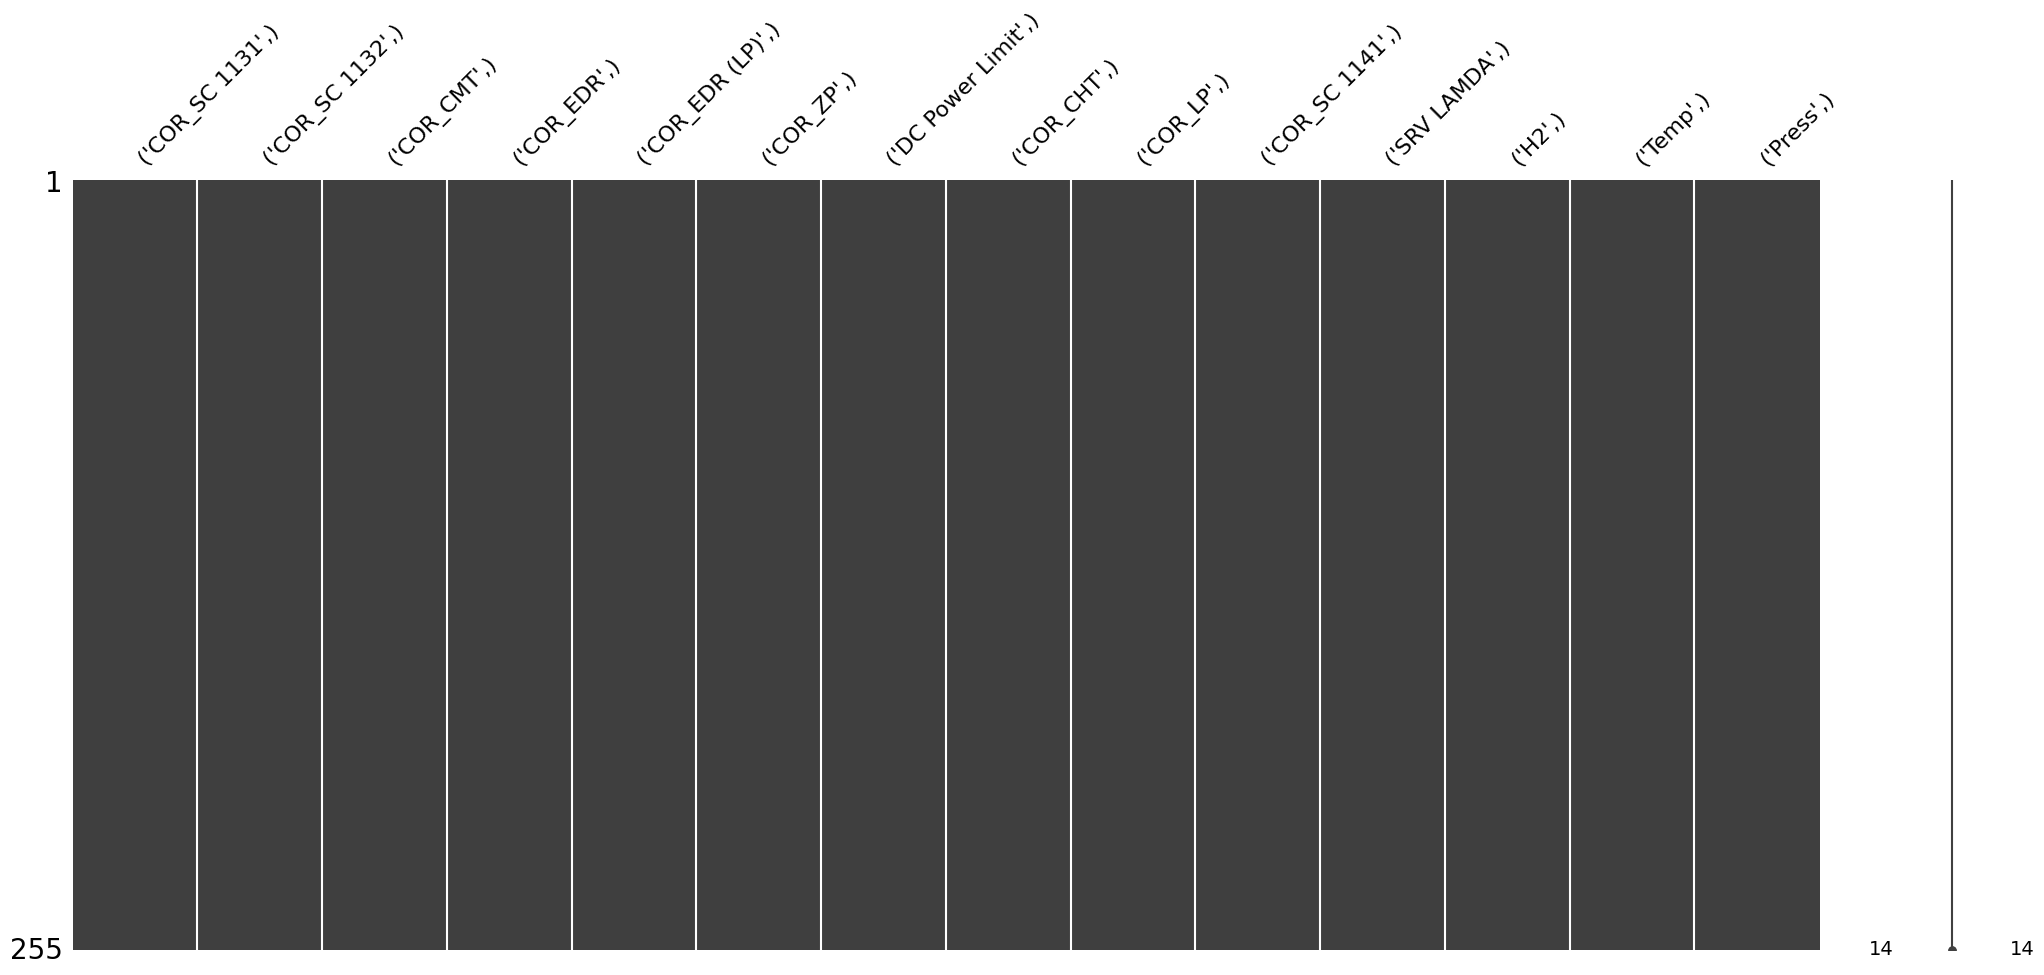

In [28]:
# visualize the missing data
msno.matrix(df_sc)

<Axes: >

findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic family 'sans-serif' not found because none of the following families were found: Helvetica
findfont: Generic f

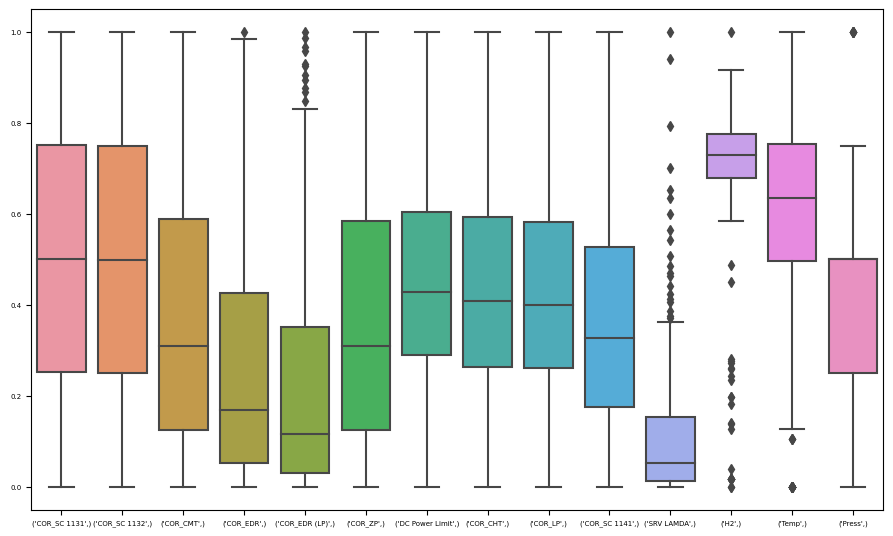

In [29]:
# visualize outliers
sn.boxplot( data=df_sc)

In [30]:
# from scipy.stats.mstats import winsorize
# from scipy.stats import mstats

# # winzorize the srv lamda and H2 columns
# df_l = df_sc['SRV LAMDA'].values
# df_e = df_sc['COR_EDR (LP)'].values
# df_h = df_sc['H2'].values
# df_lw = mstats.winsorize(df_l, limits=[df_sc['SRV LAMDA'].quantile(0.425).values[0], df_sc['SRV LAMDA'].quantile(0.575).values[0]])
# df_ew = mstats.winsorize(df_e, limits=[df_sc['COR_EDR (LP)'].quantile(0.485).values[0], df_sc['COR_EDR (LP)'].quantile(0.515).values[0]])
# df_hw = mstats.winsorize(df_h, limits=[df_sc['H2'].quantile(0.0425).values[0], df_sc['H2'].quantile(0.0975).values[0]])

# df_sc['SRV LAMDA'] =df_lw.data
# df_sc['COR_EDR (LP)'] =df_ew.data
# df_sc['H2'] =df_hw.data
# sn.boxplot( data=df_sc)

In [31]:
df_copy = df_sc.copy()

df_copy.head()

,COR_SC 1131,COR_SC 1132,COR_CMT,COR_EDR,COR_EDR (LP),COR_ZP,DC Power Limit,COR_CHT,COR_LP,COR_SC 1141,SRV LAMDA,H2,Temp,Press
0,0.433196,0.974327,0.326729,0.073381,0.402796,0.097497,0.320306,0.777087,0.237187,0.127303,0.014931,0.704269,0.529851,0.0
1,0.510020,0.635153,0.912067,0.329615,0.008461,0.580681,0.871720,0.486867,0.491747,0.748363,0.004736,0.743555,0.813433,0.5
2,0.291472,0.822607,0.048097,0.594436,0.002245,0.299218,0.326990,0.773700,0.285973,0.369341,0.027976,0.830642,0.641791,1.0
3,0.159077,0.779040,0.567005,0.332502,0.083635,0.919829,0.751202,0.303992,0.475665,0.174028,0.270308,0.762848,0.649254,0.5
4,0.789852,0.038363,0.124796,0.046430,0.142897,0.612067,0.232605,0.882012,0.384584,0.137272,0.149319,0.622450,0.671642,0.5


In [32]:
# create a copy of input data and output data and assign to variables
y = df_copy[['H2','Temp','Press']]
X = df_copy.drop(['H2','Temp','Press'], axis=1)

C:\Users\ekbotchway.IMPACTLIFE\AppData\Local\Temp\ipykernel_40356\1470917553.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df_copy.drop(['H2','Temp','Press'], axis=1)


In [33]:
X = X.values
y = y.values

In [34]:
X_train, X_test, y_train, y_test = split(X, y, test_size=0.30)
print(X_train.shape, X_test.shape, y_train.shape, y_test.shape)

(178, 11) (77, 11) (178, 3) (77, 3)


Using GA

In [35]:
# Define the parameter grid for the RandomForestRegressor
param_grid = {
    'min_weight_fraction_leaf': Continuous(0.01, 0.5, distribution='log-uniform'),
    'bootstrap': Categorical([True, False]),
    'max_depth': Integer(2, 30),
    'max_leaf_nodes': Integer(2, 35),
    'n_estimators': Integer(100, 300)
}

# Create an instance of the RandomForestRegressor estimator
pipe = RandomForestRegressor()

# Create an instance of the GASearchCV class with optimized parameters
evolved_estimator = GASearchCV(
    estimator=pipe,
    cv=10,
    scoring="r2",
    population_size=50,  # Increase population size
    generations=50,  # Increase number of generations
    tournament_size=3,
    elitism=True,
    keep_top_k=4,
    crossover_probability=0.9,
    mutation_probability=0.05,
    param_grid=param_grid,
    criteria="max",
    algorithm="eaMuCommaLambda",
    n_jobs=-1  # Enable parallel processing
)

# Optionally, define callbacks for monitoring the search progress
callbacks = [LogbookSaver(checkpoint_path="./logbook.pkl"), ProgressBar()]

# Fit the model and evaluate the results
evolved_estimator.fit(X_train, y_train, callbacks=callbacks)
y_predict_ga = evolved_estimator.predict(X_test)
r_squared = r2_score(y_test, y_predict_ga)

print(evolved_estimator.best_params_)
print("r-squared: ", "{:.2f}".format(r_squared))
print("Best k solutions: ", evolved_estimator.hof)

  0%|          | 0/51 [00:00<?, ?it/s]gen	nevals	fitness  	fitness_std	fitness_max	fitness_min
0  	50    	-0.332936	0.328966   	-0.118972  	-1.2528    
 12%|█▏        | 6/51 [14:04<2:04:46, 166.36s/it]

In [ ]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")

In [ ]:
plt.rc("text", usetex=False)
plot_search_space(evolved_estimator)

In [ ]:
plt.figure(figsize=[6,5])
plt.scatter(y_test, y_predict_ga, s=90)
# plt.xlim(left=0.86)
# plt.ylim(bottom=0.88, top=0.96)

In [ ]:
def plot_model_performance(model_name, y_test, y_predict):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=[8,5], dpi=80)

    fig.suptitle(f'Model Performance of {model_name}')
    ax1.scatter(y_test, y_predict, s=120, alpha=0.5)
    ax1.set_xlim(left=min(y_test))
    ax1.set_ylim(bottom=min(y_predict), top=max(y_predict))
    ax1.set_xlabel(r'Scaled Actual Output')
    ax1.set_ylabel(r'Scaled Predicted Output')
    ax1.set_title(r'$R^2 = {:.4g}$'.format(r2_score(y_test, y_predict)))

    # best fit of data
    data_res = y_test - y_predict 
    (mu, sigma) = stats.norm.fit(data_res[data_res > min(data_res)])

    # the histogram of the data
    n, bins, patches = ax2.hist(y_test - y_predict, 30, density=1, alpha=0.5)

    # add a 'best fit' line
    best_fit_line = scipy.stats.norm.pdf(bins, mu, sigma)
    l = ax2.plot(bins, best_fit_line, 'r--', linewidth=2)

    ax2.set_xlim(left=min(data_res))
    ax2.set_xlabel(r'Residual')
    ax2.set_ylabel(r'Frequency')
    ax2.set_title(r'$\sigma = {:.4f}$'.format(mean_squared_error(y_test, y_predict, squared=False)))

    fig.tight_layout()

    plt.show()

In [ ]:
model_name = "Hydrogen"
plot_model_performance(model_name, y_test, y_predict_ga)

In [ ]:
model_name = "Temperature"
plot_model_performance(model_name, y_test, y_predict_ga)

In [ ]:
model_name = "Pressure"
plot_model_performance(model_name, y_test, y_predict_ga)

MLP

In [ ]:
pipe = MLPRegressor()

param_grid = {
    'solver': ['lbfgs', 'sgd', 'adam'],
    'max_iter': range(500, 1500),
    'alpha': loguniform(10e-7, 10e-1),
    'hidden_layer_sizes': range(5, 12),
    'random_state': range(10)
}

# Define the GASearchCV options
evolved_estimator = GASearchCV(
    estimator=pipe,
    cv=10,
    scoring="r2",
    population_size=40,
    generations=30,
    tournament_size=3,
    elitism=True,
    keep_top_k=4,
    crossover_probability=0.9,
    mutation_probability=0.05,
    param_grid=param_grid,
    criteria="max",
    algorithm="eaMuCommaLambda",
    n_jobs=-1
)

#Optionally, create some Callbacks
callbacks = [LogbookSaver(checkpoint_path="./logbook.pkl"), ProgressBar()]

# Fit the model and see some results
evolved_estimator.fit(X_train, y_train, callbacks=callbacks)
y_predict_ga = evolved_estimator.predict(X_test)
r_squared = r2_score(y_test, y_predict_ga)

print(evolved_estimator.best_params_)
print("r-squared: ", "{:.2f}".format(r_squared))
print("Best k solutions: ", evolved_estimator.hof)

In [ ]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")

In [ ]:
plt.rc("text", usetex=False)
plot_search_space(evolved_estimator)

In [ ]:
plt.figure(figsize=[6,5])
plt.scatter(y_test, y_predict_ga, s=90)
# plt.xlim(left=0.86)
# plt.ylim(bottom=0.88, top=0.96)

In [ ]:
model_name = "Hydrogen"
plot_model_performance(model_name, y_test, y_predict_ga)

In [ ]:
model_name = "Temperature"
plot_model_performance(model_name, y_test, y_predict_ga)

In [ ]:
model_name = "Pressure"
plot_model_performance(model_name, y_test, y_predict_ga)

In [ ]:
# Reshape the target variables
y_train = np.reshape(y_train, (-1,))
y_test = np.reshape(y_test, (-1,))

# Define a custom scoring metric for R-squared
def r2_score_3d(y_true, y_pred):
    y_true = np.reshape(y_true, (-1,))
    y_pred = np.reshape(y_pred, (-1,))
    return r2_score(y_true, y_pred)

scoring_metric = make_scorer(r2_score_3d)

param_grid = {'n_iter': Integer(300, 500),
              'tol': Real(0.0001, 0.1),
              'alpha_1': Real(1.0e-7, 1e-1),
              'alpha_2': Real(1.0e-7, 1e-1),
              'lambda_1': Real(1.0e-7, 1e-1),
              'lambda_2': Real(1.0e-7, 1e-1),
              'normalize': Categorical([False, True])
              }

pipe = BayesianRidge()


# Create the CV strategy
cv = KFold(n_splits=10, shuffle=True)

# Create the EvolutionaryAlgorithmSearchCV object
evolved_estimator = GASearchCV(
    estimator=pipe,
    param_grid=param_grid,
    scoring=scoring_metric,
    cv=cv,
    population_size=40,
    generations=30,
    tournament_size=3,
    elitism=True,
    keep_top_k=4,
    crossover_probability=0.9,
    mutation_probability=0.05,
    verbose=True,
    criteria="max",
    algorithm="eaMuCommaLambda",
    n_jobs=-1
)

#Optionally, create some Callbacks
callbacks = [LogbookSaver(checkpoint_path="./logbook.pkl"), ProgressBar()]

# Fit the model and see some results
evolved_estimator.fit(X_train, y_train, callbacks=callbacks)
y_predict_ga = evolved_estimator.predict(X_test)
y_predict_ga = np.reshape(y_predict_ga, y_test.shape)
r_squared = r2_score_3d(y_test, y_predict_ga)

print(evolved_estimator.best_params_)
print("r-squared: ", "{:.2f}".format(r_squared))
print("Best k solutions: ", evolved_estimator.hof)

In [ ]:
plot = plot_fitness_evolution(evolved_estimator, metric="fitness")

In [ ]:
plt.rc("text", usetex=False)
plot_search_space(evolved_estimator)

In [ ]:
plt.figure(figsize=[6,5])
plt.scatter(y_test, y_predict_ga, s=90)
# plt.xlim(left=0.86)
# plt.ylim(bottom=0.88, top=0.96)

In [ ]:
model_name = "Hydrogen"
plot_model_performance(model_name, y_test, y_predict_ga)

In [ ]:
model_name = "Temperature"
plot_model_performance(model_name, y_test, y_predict_ga)

In [ ]:
model_name = "Pressure"
plot_model_performance(model_name, y_test, y_predict_ga)